Let's consider the following problem:

$$
\begin{align}
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \quad u = u(t,x), \quad x\in[0,1],\\
u(0,x) = \sin(2\pi x),\\
u(0,t) = u(1,t) = 0,
\end{align}
$$


In [1]:
# Tell Colab we want to use TF2
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
# Import desired packages
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow.compat.v1 as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

K.backend.set_floatx('float64')

In [3]:
# Build the NN model
network = K.Sequential()
network.add(K.layers.Dense(16, 'tanh'))
network.add(K.layers.Dense(16, 'tanh'))
network.add(K.layers.Dense(1))

## Define the solution and problem setup
With our neural network model ready, we can now write our solution as a function of the neural network and implement the heat equation. Since we have a simple problem in 1D, the boundary and initial conditions are most easily implemented by construction. Therefore, we will write the solution as

$$
\hat{u}(t,x) = g(x) + t\,x\,(x-1)\;N(2t-1,2x-1),
$$
where $g(x) = \sin(2\pi x)$ is the initial condition and $N$ is the neural network which will take a time and space coordinate. Note that we have scaled the coordinates to be between -1 and 1 when passing them to the network function in order to leverage the full range of the first hyperbolic tangent activation.


In [5]:
def initial_condition(x):
    return tf.sin(2*np.pi*x)

def solution_1d(t, x):
    return t*x*(1.0-x)*network(tf.concat([2*t-1,2*x-1], 1)) + initial_condition(x)

def heat_equation_1d(t, x):
    alpha = 1.0/(4.0*np.pi*np.pi)
    with tf.GradientTape() as tape1:
        tape1.watch(x)
    with tf.GradientTape() as tape2:
        tape2.watch([t,x])
        u = solution_1d(t, x)
    u_t, u_x = tape2.gradient(u, [t, x])
    u_xx = tape1.gradient(u_x, x)
    return u_t - alpha*u_xx

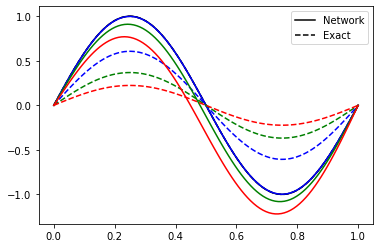

In [6]:
# Plot the solution at half-second intervals
def plot_solution():
    x = np.reshape(np.linspace(0,1,100), (100,1))
    for i,c in enumerate(['k', 'b', 'g', 'r']):
        t = 0.5 * i * np.ones((100,1))
        u_network = solution_1d(t, x).numpy()
        u_exact = np.exp(-t)*np.sin(2*np.pi*x)
        plt.plot(x, u_network, c+'-')
        plt.plot(x, u_exact, c+'--')
    plt.legend(['Network', 'Exact'])

plot_solution()

### Define the loss function
Next let's define the loss function. Recall that this will be the L2 norm error, evaluated on our set of collocation points, which will be passed into the loss function. It minimizes the sum of L2 norms of the equation along with the boundary conditions.

In [7]:
def loss(t, x):
    pde_loss = tf.reduce_mean(
    tf.square(heat_equation_1d(t, x)))
    return pde_loss

### Training the network

With the network, solution, PDE, and loss function defined, it is time to actually train the network on our PDE. Training is done in the following steps:

Define an optimizer: this selects the optimization algorithm to use. We will use the Adam algorithm which is a gradient descent method incorporating momentum and adaptive learning rate scaling.
Define our collocation points: here we will simply use a grid of 50x50 points on the $(t,x)$ domain.
For each epoch:
Compute the current loss and it's gradient w.r.t. network parameters
Apply the gradients with the optimizer to update the network parameters

In [8]:
def grad(t, x):
    with tf.GradientTape() as tape:
        loss_value = loss(t, x)
    return loss_value, tape.gradient(loss_value, network.trainable_variables)

def train(num_epochs=500):
    optimizer = K.optimizers.Adam(learning_rate=0.01)

    t, x = np.meshgrid(np.linspace(0,2,50), np.linspace(0,1,50))
    t = tf.convert_to_tensor(np.reshape(t, (-1,1)))
    x = tf.convert_to_tensor(np.reshape(x, (-1,1)))

    for epoch in range(num_epochs):
        loss_value, grads = grad(t, x)
        optimizer.apply_gradients(zip(grads, network.trainable_variables))
        if epoch % 100 == 0:
            print(f'{epoch}: loss = {loss_value}')
            
train()

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [42]:
#Anirrudh Ramesh
#framework provided by Jiahao
import time
import matplotlib.pyplot as plt
#import tensorflow as tf
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import numpy as np
from tensorflow . python . training . moving_averages \
import assign_moving_average
from scipy . stats import multivariate_normal as normal
from tqdm.notebook import tqdm

from tensorflow . python . ops import control_flow_ops
from tensorflow import random_normal_initializer as norm_init
from tensorflow import random_uniform_initializer as unif_init
from tensorflow import constant_initializer as const_init

In [50]:
class framework(object):
    """The fully - connected neural network model."""
    def __init__(self, sess, n_int):
        self.sess = sess
        self.n_simple_train1 = n_int
    # parameters for the function we want to approximate
        self.domain_bound = 150   # boundary value M
        self.terminal_time = 1
        
    # parameters for the algorithm
#         self.n_simple_train1 = 500 # number samples in training set 
        self.n_simple_train2 = 300
        self.n_simple_train3 = 300
        self.n_simple_valid = 2000 # number samples in validation set

        self.hidden_neuron = 50  #number of neurons in each layer 
        self.n_neuron = [1, self.hidden_neuron, self.hidden_neuron, 1] 
        #structure of of neural net
        
    
        self.n_maxstep = 100000 # number of maximum iteration
        self.n_displaystep = 1000 # every n_displaystep steps, we output some information
        self.picdisplaystep= 200 # every picdisplaystep steps, we output graph
        self.learning_rate = 5e-3
        
        # some basic constants and variables
        self._extra_train_ops = []
        self.tolerence = 5e-6
        
    def train(self):
        start_time = time.time()
        trainable_vars = tf.trainable_variables()
        grads = tf.gradients(self.loss, trainable_vars)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        apply_op = \
                optimizer.apply_gradients(zip(grads, trainable_vars))
        train_ops = [apply_op] + self._extra_train_ops
        self.train_op = tf.group(* train_ops)

        self.loss_history = []
        self.time_history = []
        
#=============================================================================
# You can change the code in this block if needed. But make sure always feed 
# neural net what it needs. 
        x_valid1 = self.sample_point_X1(self.n_simple_valid)
        x_valid2 = self.sample_point_X2(self.n_simple_valid)
        x_valid3 = self.sample_point_X3(self.n_simple_valid)
        feed_dict_valid = {self.Xi: x_valid1, self.Xb: x_valid2, self.Xt: x_valid3, self.is_training: False}
#=============================================================================
        print("before initialized")
        
        # initialization
        step = 1
        self.sess.run(tf.global_variables_initializer())
        temp_loss = self.sess.run(self.loss,
                                  feed_dict = feed_dict_valid)
        self.loss_history.append(temp_loss)
        self.time_history.append(0)
        
        print("step: %5u, loss: %.4e," % \
              (0, temp_loss))
        
        #x_test_gradient = np.array([[0],[1],[2],[3]])
        #gradient_test = self.sess.run(self.gradient_test,
                                     #feed_dict = {self.X: x_test_gradient,
                                                 #self.is_training: False})
        
        # begin sgd iteration
        # for iii in range (self.n_maxstep + 2):
        while (self.loss_history[-1] > self.tolerence) and (step < self.n_maxstep) :
             x_train1 = self.sample_point_X1(self.n_simple_train1)
             x_train2 = self.sample_point_X2(self.n_simple_train2)
             x_train3 = self.sample_point_X3(self.n_simple_train3)
             self.sess.run(self.train_op,
                           feed_dict = {self.Xi: x_train1, self.Xb: x_train2, self.Xt: x_train3,
                                       self.is_training: True})
             if step % self.n_displaystep == 0:
                 temp_loss = self.sess.run(self.loss,
                                           feed_dict = feed_dict_valid)
                 self.loss_history.append(temp_loss)
                 self.time_history.append(time.time() - start_time + self.t_bd)
                 print ("step: %5u, loss: %.4e, time: %5u" % \
                        (step , temp_loss, time.time() - start_time))

             #if step % self .picdisplaystep == 0:
                     #approximate_f = self.sess.run(self.output,
                                                   #feed_dict = feed_dict_valid)                     
                     #plt.scatter(x_valid, approximate_f, label = 'approximation of neural net')
                     #plt.scatter(x_valid, self.f(x_valid), label = 'real function f')
                     #plt.legend()
                     #plt.show()
             step += 1

        x1 = [[0, 100], [1, 90], [1, 80], [1, 110]]
        self.outputsample = self.sess.run(self.output, 
                                          feed_dict = {self.Xi: x1, self.Xb: x_valid2, 
                                                       self.Xt: x_valid3, self.is_training: False})
#         print("Loss history", self.loss_history)
        return self.loss_history
#=============================================================================        
# You will need to rewrite this block. 
    def build(self):
        start_time = time.time()
        self.Xi = tf.placeholder(tf.float64, [None, 2], name = 'Xi') # interior
        self.Xb = tf.placeholder(tf.float64, [None, 2], name = 'Xb') # boundary
        self.Xt = tf.placeholder(tf.float64, [None, 2], name = 'Xt') # terminal
        self.is_training = tf.placeholder(tf.bool)
        
# the variable f_ is output of neural net given certain input.       
        c_interior = self._one_time_net(self.Xi, 'c')[:,0]
        c_boundary = self._one_time_net(self.Xb, 'c')[:,0]
        c_terminal = self._one_time_net(self.Xt, 'c')[:,0]
        
# loss function here is just L2 norm of difference of this two function.
        c_interior_dt = tf.gradients(c_interior, self.Xi)[0][:,0]
        c_interior_dx = tf.gradients(c_interior, self.Xi)[0][:,1]
        c_interior_dxx = tf.gradients(c_interior_dx, self.Xi)[0][:,1]
        c_boundary_dx = tf.gradients(c_boundary, self.Xb)[0][:,1]
        
        loss_terminal = c_terminal - tf.math.maximum(self.Xt[:,1]-90, 0)
        loss_boundary = c_boundary_dx - 1
        loss_interior = c_interior_dt + 0.01*tf.math.multiply(self.Xi[:,1], c_interior_dx) 
        + 0.5*0.04*tf.math.multiply(tf.math.square(self.Xi[:,1]), c_interior_dxx) - 0.01*c_interior
    
        self.loss = tf.reduce_mean((loss_terminal)**2) + tf.reduce_mean((loss_boundary)**2) + tf.reduce_mean((loss_interior)**2)
        
# test of tf.gradient function
        #self.gradient_test = tf.gradients(self.f(self.X), self.X)
#=============================================================================  
        self.output = c_interior
        self.t_bd = time.time() - start_time        
        print('end of build')
#=============================================================================        
# this function define how we sample points in domain
    def sample_point_X1(self, n_sample1): #interior
        t = np.random.uniform(low = 0, high = self.terminal_time, size = (n_sample1, 1))
        x = np.random.uniform(low = 0, high = self.domain_bound, size = (n_sample1, 1))
        X = np.hstack((t, x))
        X
        return X
    
    def sample_point_X2(self, n_sample2): # boundary x=M
        t = np.random.uniform(low = 0, high = self.terminal_time, size = (n_sample2, 1))
        x = np.ones((n_sample2, 1)) * self.domain_bound
        X = np.hstack((t, x))
        X
        return X
    
    def sample_point_X3(self, n_sample3): # terminal t=T
        t = np.ones((n_sample3, 1)) * self.terminal_time
        x = np.random.uniform(low = 0, high = self.domain_bound, size = (n_sample3, 1))
        X = np.hstack((t, x))
        X
        return X
    
# this is the function we want to approximate
#    def f(self, x):
#        return x**3
    
# you can change number of layer or activation function if needed
    def _one_time_net(self, x, name):
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            layer1 = self._one_layer(x, self.n_neuron[1], activation_fn = tf.nn.elu, name = 'layer1')
            layer2 = self._one_layer(layer1, self.n_neuron[2], activation_fn = tf.nn.relu,  name = 'layer2')
            layer3 = self._one_layer(layer2, self.n_neuron[2], activation_fn = tf.nn.relu,  name = 'layer2')
            u = self._one_layer(layer3, self.n_neuron[3], activation_fn = None ,name ='final')
        return u

# you can change initialization of weight in each layer if needed
    def _one_layer(self, input_, out_sz,
                   activation_fn = None,
                   std =1.0, name = 'linear'):
        with tf.variable_scope(name,):
            shape = input_.get_shape().as_list()
            w = tf.get_variable('Matrix',
                                [shape[1], out_sz], tf.float64,
                                norm_init(stddev = \
                                          std / np.sqrt(shape[1] + out_sz)))
            hidden = tf.matmul(input_, w)
        if activation_fn != None:
            return activation_fn(hidden)
        else:
            return hidden

#if __name__ == '__main__ ':
#    np.random.seed(1)
#    main()
#main()

n_ints = np.arange(300,625,25)
# n_ints = [300]
losses = []
for n_int in n_ints:
    print("N_INT = ", n_int)
    with tf.Session(graph=tf.Graph()) as sess:
        tf.set_random_seed(1)
        print("begin to solve approximation")
        model = framework(sess, n_int=n_int)
        model.build()
        loss_history = model.train()
        output = np.zeros((len(model.loss_history), 3))
        output[:,0] = np.arange(len(model.loss_history)) \
        * model.n_displaystep
        output[:,1] = model.loss_history
        output[:,2] = model.time_history
        outputsample = model.outputsample
        print("Opsample: ", outputsample)
        avgloss = np.median(loss_history[-10:])
        print("Average loss: ", avgloss)
        losses.append(avgloss)

N_INT =  300
begin to solve approximation
end of build
before initialized
step:     0, loss: 4.4646e+02,
step:  1000, loss: 5.2288e-02, time:     2
step:  2000, loss: 2.2499e+00, time:     5
step:  3000, loss: 1.7745e-01, time:     7
step:  4000, loss: 5.2777e-01, time:     9
step:  5000, loss: 2.1447e-02, time:    12
step:  6000, loss: 3.3354e-03, time:    14
step:  7000, loss: 1.2069e-02, time:    17
step:  8000, loss: 1.8124e-02, time:    20
step:  9000, loss: 3.4283e-02, time:    23
step: 10000, loss: 3.5996e-03, time:    25
step: 11000, loss: 1.8893e-02, time:    28
step: 12000, loss: 3.0109e-02, time:    30
step: 13000, loss: 3.5192e-03, time:    33
step: 14000, loss: 3.1230e-03, time:    36
step: 15000, loss: 7.4821e-03, time:    39
step: 16000, loss: 7.0900e-03, time:    42
step: 17000, loss: 3.7283e-03, time:    44
step: 18000, loss: 2.0732e-03, time:    47
step: 19000, loss: 1.3851e-01, time:    50
step: 20000, loss: 4.0574e-02, time:    53
step: 21000, loss: 9.3493e-04, time

step: 86000, loss: 1.3219e-03, time:   292
step: 87000, loss: 2.4428e-03, time:   295
step: 88000, loss: 1.1615e-03, time:   299
step: 89000, loss: 2.6632e-03, time:   303
step: 90000, loss: 2.6715e-03, time:   306
step: 91000, loss: 2.8292e-03, time:   311
step: 92000, loss: 3.1240e-03, time:   314
step: 93000, loss: 1.4284e-03, time:   318
step: 94000, loss: 1.7948e-03, time:   322
step: 95000, loss: 2.7832e-03, time:   326
step: 96000, loss: 3.5848e-03, time:   330
step: 97000, loss: 1.2273e-03, time:   333
step: 98000, loss: 1.5476e-02, time:   336
step: 99000, loss: 6.6778e-04, time:   340
Opsample:  [ 1.21265793e+01  9.30989621e-01 -2.77569817e-03  2.12494331e+01]
Average loss:  0.0027273528088623336
N_INT =  350
begin to solve approximation
end of build
before initialized
step:     0, loss: 4.5819e+02,
step:  1000, loss: 1.3480e-02, time:     4
step:  2000, loss: 1.7857e-02, time:     7
step:  3000, loss: 1.4237e-02, time:    11
step:  4000, loss: 5.0613e-03, time:    15
step:  

step: 69000, loss: 1.3342e-02, time:   240
step: 70000, loss: 6.1752e-03, time:   244
step: 71000, loss: 1.0941e-03, time:   248
step: 72000, loss: 8.3414e-04, time:   251
step: 73000, loss: 3.0320e-03, time:   255
step: 74000, loss: 8.6299e-04, time:   259
step: 75000, loss: 1.3354e-02, time:   263
step: 76000, loss: 1.1810e-02, time:   266
step: 77000, loss: 6.5684e-04, time:   270
step: 78000, loss: 1.4592e-03, time:   274
step: 79000, loss: 1.0724e-03, time:   278
step: 80000, loss: 6.9252e-04, time:   281
step: 81000, loss: 1.0582e-02, time:   285
step: 82000, loss: 1.2423e-03, time:   289
step: 83000, loss: 2.4917e-03, time:   293
step: 84000, loss: 3.7084e-03, time:   297
step: 85000, loss: 1.6060e-03, time:   301
step: 86000, loss: 2.5675e-03, time:   304
step: 87000, loss: 1.4729e-03, time:   309
step: 88000, loss: 3.3003e-03, time:   313
step: 89000, loss: 6.2371e-04, time:   316
step: 90000, loss: 9.5342e-04, time:   320
step: 91000, loss: 3.3122e-03, time:   323
step: 92000

step: 52000, loss: 1.8105e-03, time:   207
step: 53000, loss: 6.5398e-04, time:   211
step: 54000, loss: 4.1859e-01, time:   215
step: 55000, loss: 2.0928e-03, time:   219
step: 56000, loss: 1.0322e-01, time:   223
step: 57000, loss: 2.3108e-02, time:   227
step: 58000, loss: 1.7964e-03, time:   231
step: 59000, loss: 8.1505e-04, time:   236
step: 60000, loss: 3.8106e-03, time:   241
step: 61000, loss: 7.8843e-04, time:   245
step: 62000, loss: 1.8367e-03, time:   250
step: 63000, loss: 1.4911e-03, time:   254
step: 64000, loss: 1.1247e-03, time:   259
step: 65000, loss: 3.3592e-02, time:   263
step: 66000, loss: 9.0209e-04, time:   268
step: 67000, loss: 1.2109e-03, time:   272
step: 68000, loss: 1.4068e-03, time:   277
step: 69000, loss: 3.0859e-03, time:   282
step: 70000, loss: 2.4698e-02, time:   286
step: 71000, loss: 7.5597e-04, time:   291
step: 72000, loss: 1.9784e-02, time:   295
step: 73000, loss: 1.4202e-03, time:   300
step: 74000, loss: 1.1580e-02, time:   304
step: 75000

step: 35000, loss: 2.9413e-03, time:   158
step: 36000, loss: 1.5714e-02, time:   163
step: 37000, loss: 2.9843e-03, time:   167
step: 38000, loss: 1.2614e-03, time:   171
step: 39000, loss: 9.9233e-04, time:   176
step: 40000, loss: 1.6853e-03, time:   180
step: 41000, loss: 2.1422e-03, time:   184
step: 42000, loss: 1.1444e-03, time:   189
step: 43000, loss: 1.1068e-03, time:   193
step: 44000, loss: 1.1018e-03, time:   198
step: 45000, loss: 2.2405e-03, time:   202
step: 46000, loss: 1.0081e-02, time:   206
step: 47000, loss: 9.3933e-04, time:   210
step: 48000, loss: 4.7967e-02, time:   215
step: 49000, loss: 2.0326e-03, time:   219
step: 50000, loss: 9.4533e-04, time:   223
step: 51000, loss: 5.9781e-02, time:   227
step: 52000, loss: 1.9923e-02, time:   231
step: 53000, loss: 1.6594e-03, time:   236
step: 54000, loss: 8.3352e-04, time:   240
step: 55000, loss: 7.7405e-04, time:   245
step: 56000, loss: 7.5025e-03, time:   249
step: 57000, loss: 4.2616e-03, time:   253
step: 58000

step: 18000, loss: 2.9253e-02, time:    71
step: 19000, loss: 4.0989e-03, time:    74
step: 20000, loss: 2.2582e-02, time:    78
step: 21000, loss: 4.5691e-04, time:    85
step: 22000, loss: 3.9814e-03, time:    90
step: 23000, loss: 2.4780e-03, time:    95
step: 24000, loss: 6.2709e-03, time:    99
step: 25000, loss: 2.0351e-03, time:   103
step: 26000, loss: 2.3552e-01, time:   107
step: 27000, loss: 8.7927e-03, time:   112
step: 28000, loss: 1.3922e-03, time:   116
step: 29000, loss: 8.4592e-03, time:   120
step: 30000, loss: 1.3022e-03, time:   124
step: 31000, loss: 1.2315e-03, time:   128
step: 32000, loss: 1.5591e-01, time:   132
step: 33000, loss: 2.7070e-02, time:   137
step: 34000, loss: 3.3256e-02, time:   141
step: 35000, loss: 5.3839e-03, time:   146
step: 36000, loss: 1.0837e-03, time:   150
step: 37000, loss: 2.1170e-01, time:   155
step: 38000, loss: 3.0339e-02, time:   159
step: 39000, loss: 1.0211e-03, time:   164
step: 40000, loss: 1.7005e-01, time:   168
step: 41000

step:  2000, loss: 4.4846e-02, time:     9
step:  3000, loss: 1.0842e-02, time:    14
step:  4000, loss: 1.3257e-02, time:    18
step:  5000, loss: 2.3185e-01, time:    23
step:  6000, loss: 1.8673e-03, time:    27
step:  7000, loss: 1.9789e-03, time:    32
step:  8000, loss: 4.2998e-02, time:    37
step:  9000, loss: 1.3807e-02, time:    41
step: 10000, loss: 4.1165e-03, time:    46
step: 11000, loss: 8.1049e-03, time:    51
step: 12000, loss: 3.7582e-03, time:    55
step: 13000, loss: 7.0482e-03, time:    60
step: 14000, loss: 1.5224e-02, time:    64
step: 15000, loss: 4.9777e-02, time:    69
step: 16000, loss: 5.3723e-01, time:    74
step: 17000, loss: 2.2070e-03, time:    78
step: 18000, loss: 3.1557e-03, time:    83
step: 19000, loss: 8.2141e-03, time:    87
step: 20000, loss: 3.1475e-01, time:    92
step: 21000, loss: 5.3947e-03, time:    96
step: 22000, loss: 2.1157e-03, time:   101
step: 23000, loss: 1.9742e-03, time:   106
step: 24000, loss: 4.6731e-03, time:   110
step: 25000

step: 89000, loss: 9.1833e-03, time:   402
step: 90000, loss: 6.5241e-04, time:   407
step: 91000, loss: 1.2474e-03, time:   411
step: 92000, loss: 7.5274e-04, time:   416
step: 93000, loss: 3.3192e-03, time:   420
step: 94000, loss: 2.4449e-03, time:   425
step: 95000, loss: 1.2406e-03, time:   430
step: 96000, loss: 8.6960e-03, time:   434
step: 97000, loss: 1.4073e-02, time:   439
step: 98000, loss: 1.0306e-03, time:   443
step: 99000, loss: 6.3872e-04, time:   448
Opsample:  [1.10187518e+01 1.91237301e-02 0.00000000e+00 1.99934592e+01]
Average loss:  0.0012439886633314314


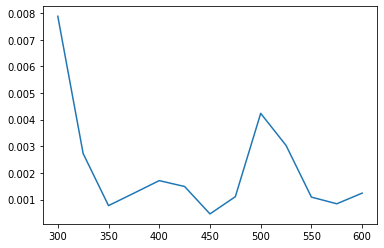

In [60]:
plt.plot(n_ints,losses)

(0, 0.001)

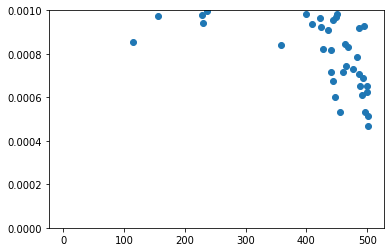

In [33]:
x = np.arange(1,len(loss_history)+1)
loss_history = np.array(loss_history)
plt.scatter(x, loss_history)
plt.ylim(0,0.001)

In [51]:
losses

[0.007879015266185093,
 0.0027273528088623336,
 0.0007754426123786518,
 0.0012420986369973959,
 0.001713463466750868,
 0.001492500232346537,
 0.00046439326591166184,
 0.0011113143625597628,
 0.004236110856732185,
 0.0030329148407122696,
 0.0010945548112888685,
 0.0008446624200916185,
 0.0012439886633314314]

Text(0, 0.5, 'Convergence rate (time)')

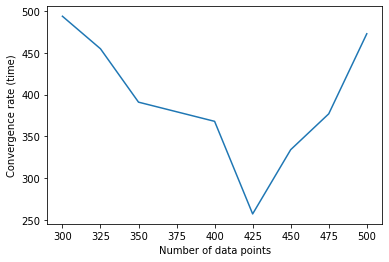

In [12]:

x = [500,475 ,450 ,425, 400 ,350 ,325, 300]
y = [473 ,377, 334, 257, 368 ,391 ,455, 494]
plt.plot(x,y)
plt.xlabel("Number of data points")
plt.ylabel("Convergence rate (time)")

## Interpolation

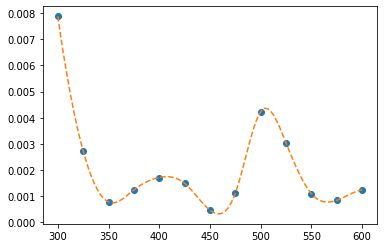

In [64]:
from scipy.interpolate import interp1d
x = n_ints
y = losses
f = interp1d(x,y, kind='cubic')
xnew = np.linspace(300,600,num=101, endpoint=True)
ynew = f(xnew)
plt.plot(x, y, 'o', xnew, f(xnew), '--')
plt.show()

In [65]:
f(xnew)

array([0.00787902, 0.0070846 , 0.00633904, 0.00564196, 0.00499299,
       0.00439174, 0.00383783, 0.00333088, 0.00287052, 0.00245636,
       0.00208802, 0.00176513, 0.0014873 , 0.00125415, 0.00106531,
       0.00092039, 0.00081902, 0.00076078, 0.00074309, 0.00076004,
       0.00080545, 0.00087309, 0.00095678, 0.00105031, 0.00114748,
       0.0012421 , 0.00132902, 0.00140733, 0.0014772 , 0.00153877,
       0.00159219, 0.00163763, 0.00167524, 0.00170517, 0.00172748,
       0.00174121, 0.00174473, 0.0017364 , 0.00171457, 0.0016776 ,
       0.00162384, 0.00155167, 0.00145946, 0.00134818, 0.0012227 ,
       0.00108825, 0.00095006, 0.00081335, 0.00068335, 0.00056529,
       0.00046439, 0.00038609, 0.00033665, 0.00032254, 0.00035024,
       0.00042622, 0.00055696, 0.00074893, 0.00100859, 0.00134099,
       0.00173435, 0.00216604, 0.00261328, 0.00305327, 0.00346321,
       0.0038203 , 0.00410175, 0.004285  , 0.00436115, 0.00434254,
       0.0042433 , 0.00407758, 0.00385954, 0.00360331, 0.00332

## GAN

In [110]:
# define and fit a discriminator model
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [111]:
# define the standalone discriminator model
# retain
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
# retain
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(20, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(50, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(20, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(n_outputs, activation='linear'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
# retain
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [112]:
# generate n real samples with class labels
# to be changed
# def generate_real_samples(n):
# 	# generate inputs in [-0.5, 0.5]
# 	X1 = rand(n) - 0.5
# 	# generate outputs X^2
# 	X2 = X1 * X1
# 	# stack arrays
# 	X1 = X1.reshape(n, 1)
# 	X2 = X2.reshape(n, 1)
# 	X = hstack((X1, X2))
# 	# generate class labels
# 	y = ones((n, 1))
# 	return X, y

# n = 101
def generate_real_samples(n):
	xnew = np.linspace(300,600,num=n,endpoint=True)
	ynew = f(xnew)
	X1 = xnew.reshape(n,1)
	X2 = ynew.reshape(n,1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = 100*randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	print("Latent shape: ", x_input.shape)
	return x_input
 
# use the generator to generate n fake examples, with class labels
# retain
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=101):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=2)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=2)
	# summarize discriminator performance
	print("Epoch: {}, Acc_real: {}, Acc_fake: {}".format(epoch, acc_real, acc_fake))
	# scatter plot real and fake data points
	plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
	plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	plt.xlabel('n_int')
	plt.ylabel('loss')
	plt.show()
	return x_fake

In [113]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=200):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	xfakes = []
	# manually enumerate epochs
	for i in range(n_epochs):
		print("Epoch: ",i)
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		print("Xfake shape: ", x_fake.shape)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			xfakes.append(summarize_performance(i, g_model, d_model, latent_dim))
# 			summarize_performance(i, g_model, d_model, latent_dim)
	return xfakes

Epoch:  0
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  10
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  11
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  12
Latent shape:  (64, 5)
Xfake shape:  (6

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  104
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  105
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  106
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  107
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  108
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  109
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  110
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  111
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  112
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  113
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  114
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  115
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent

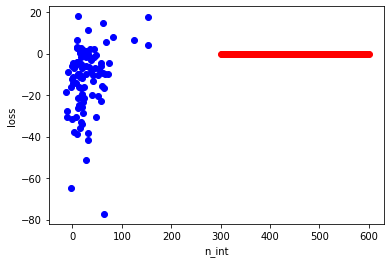

Epoch:  200
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  201
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  202
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  203
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  204
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  205
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  206
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  207
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  208
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  209
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  210
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  211
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  212
Latent shape:  (

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  304
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  305
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  306
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  307
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  308
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  309
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  310
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  311
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  312
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  313
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  314
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  315
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent

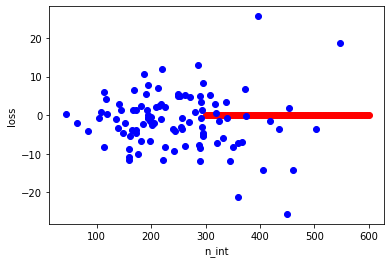

Epoch:  400
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  401
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  402
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  403
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  404
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  405
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  406
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  407
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  408
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  409
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  410
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  411
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  412
Latent shape:  (

Latent shape:  (128, 5)
Epoch:  502
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  503
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  504
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  505
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  506
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  507
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  508
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  509
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  510
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  511
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  512
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  513
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoc

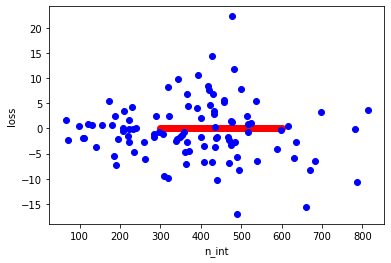

Epoch:  600
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  601
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  602
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  603
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  604
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  605
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  606
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  607
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  608
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  609
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  610
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  611
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  612
Latent shape:  (

Epoch:  703
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  704
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  705
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  706
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  707
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  708
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  709
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  710
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  711
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  712
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  713
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  714
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  715
Latent shape:  (

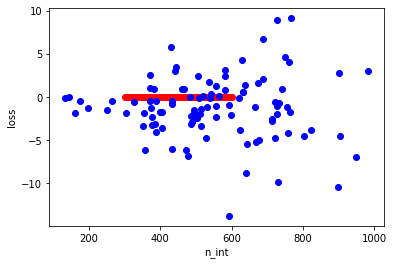

Epoch:  800
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  801
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  802
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  803
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  804
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  805
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  806
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  807
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  808
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  809
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  810
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  811
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  812
Latent shape:  (

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  904
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  905
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  906
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  907
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  908
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  909
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  910
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  911
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  912
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  913
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  914
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  915
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent

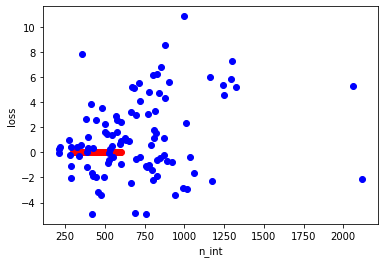

Epoch:  1000
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1001
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1002
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1003
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1004
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1005
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1006
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1007
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1008
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1009
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1010
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1011
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1012
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1102
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1103
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1104
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1105
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1106
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1107
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1108
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1109
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1110
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1111
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1112
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1113
Latent shape:  (64, 5)
Xfake shape:  (6

Epoch: 1199, Acc_real: 0.0, Acc_fake: 1.0


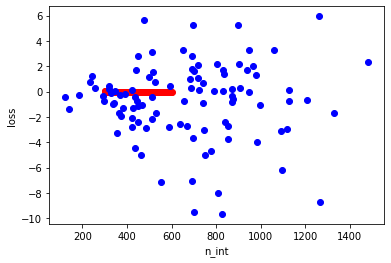

Epoch:  1200
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1201
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1202
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1203
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1204
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1205
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1206
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1207
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1208
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1209
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1210
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1211
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1212
Lat

Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1303
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1304
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1305
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1306
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1307
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1308
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1309
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1310
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1311
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1312
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1313
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1314
Latent shape:  (

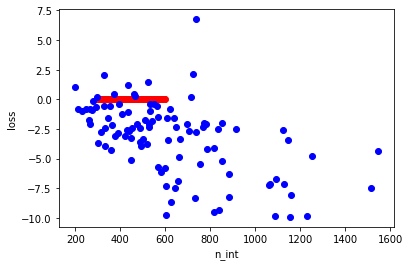

Epoch:  1400
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1401
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1402
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1403
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1404
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1405
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1406
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1407
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1408
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1409
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1410
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1411
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1412
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1501
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1502
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1503
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1504
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1505
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1506
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1507
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1508
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1509
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1510
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1511
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1512
Latent shape:  (64, 5)
Xfake shape:  (6

Latent shape:  (101, 5)
4/4 - 0s - loss: 0.3719 - accuracy: 1.0000
Epoch: 1599, Acc_real: 0.0, Acc_fake: 1.0


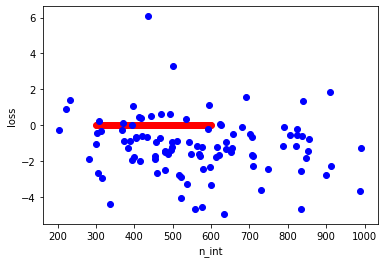

Epoch:  1600
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1601
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1602
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1603
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1604
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1605
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1606
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1607
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1608
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1609
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1610
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1611
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1612
Lat

Latent shape:  (128, 5)
Epoch:  1701
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1702
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1703
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1704
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1705
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1706
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1707
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1708
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1709
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1710
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1711
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1712
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (

Epoch: 1799, Acc_real: 0.594059405940594, Acc_fake: 0.9504950495049505


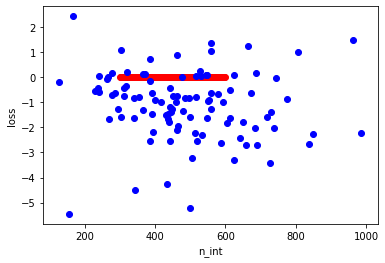

Epoch:  1800
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1801
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1802
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1803
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1804
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1805
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1806
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1807
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1808
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1809
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1810
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1811
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1812
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1901
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1902
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1903
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1904
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1905
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1906
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1907
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1908
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1909
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1910
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1911
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  1912
Latent shape:  (64, 5)
Xfake shape:  (6

Latent shape:  (101, 5)
4/4 - 0s - loss: 0.5837 - accuracy: 0.7129
Epoch: 1999, Acc_real: 1.0, Acc_fake: 0.7128712871287128


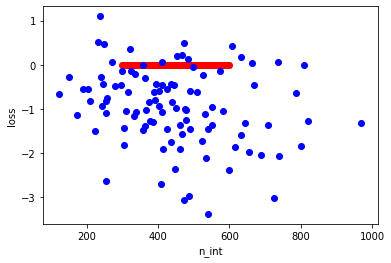

Epoch:  2000
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2001
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2002
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2003
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2004
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2005
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2006
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2007
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2008
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2009
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2010
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2011
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2012
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2102
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2103
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2104
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2105
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2106
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2107
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2108
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2109
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2110
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2111
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2112
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2113
Latent shape:  (64, 5)
Xfake shape:  (6

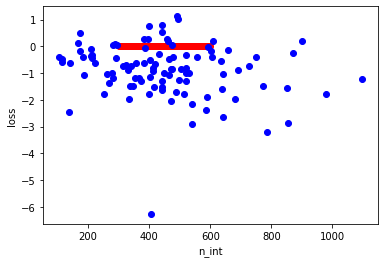

Epoch:  2200
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2201
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2202
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2203
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2204
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2205
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2206
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2207
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2208
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2209
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2210
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2211
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2212
Lat

Epoch:  2300
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2301
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2302
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2303
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2304
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2305
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2306
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2307
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2308
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2309
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2310
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2311
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2312
Lat

Latent shape:  (101, 5)
4/4 - 0s - loss: 0.5903 - accuracy: 0.6535
Epoch: 2399, Acc_real: 1.0, Acc_fake: 0.6534653465346535


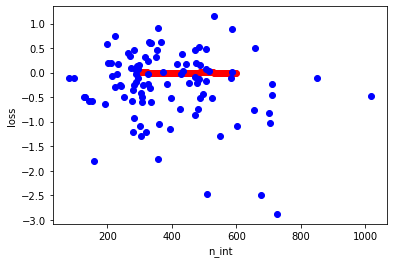

Epoch:  2400
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2401
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2402
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2403
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2404
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2405
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2406
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2407
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2408
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2409
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2410
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2411
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2412
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2502
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2503
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2504
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2505
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2506
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2507
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2508
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2509
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2510
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2511
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2512
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2513
Latent shape:  (64, 5)
Xfake shape:  (6

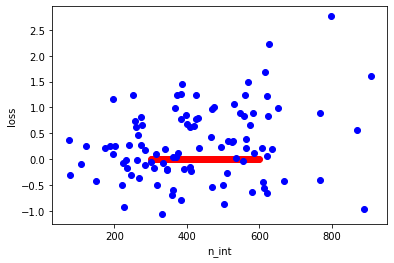

Epoch:  2600
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2601
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2602
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2603
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2604
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2605
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2606
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2607
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2608
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2609
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2610
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2611
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2612
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2701
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2702
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2703
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2704
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2705
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2706
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2707
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2708
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2709
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2710
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2711
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2712
Latent shape:  (64, 5)
Xfake shape:  (6

Latent shape:  (101, 5)
4/4 - 0s - loss: 0.4807 - accuracy: 0.8911
Epoch: 2799, Acc_real: 0.49504950495049505, Acc_fake: 0.8910891089108911


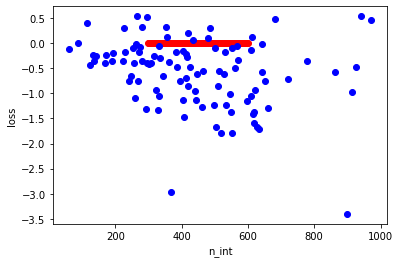

Epoch:  2800
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2801
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2802
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2803
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2804
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2805
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2806
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2807
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2808
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2809
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2810
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2811
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2812
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2901
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2902
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2903
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2904
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2905
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2906
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2907
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2908
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2909
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2910
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2911
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  2912
Latent shape:  (64, 5)
Xfake shape:  (6

Latent shape:  (101, 5)
4/4 - 0s - loss: 0.4206 - accuracy: 0.9802
Epoch: 2999, Acc_real: 0.0, Acc_fake: 0.9801980198019802


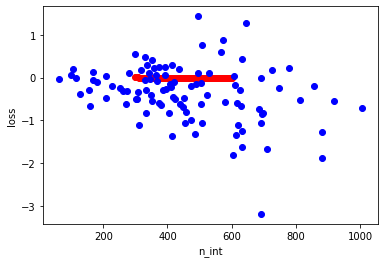

Epoch:  3000
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3001
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3002
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3003
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3004
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3005
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3006
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3007
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3008
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3009
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3010
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3011
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3012
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3102
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3103
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3104
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3105
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3106
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3107
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3108
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3109
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3110
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3111
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3112
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3113
Latent shape:  (64, 5)
Xfake shape:  (6

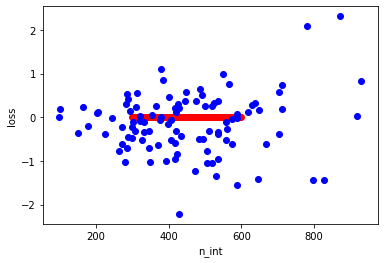

Epoch:  3200
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3201
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3202
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3203
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3204
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3205
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3206
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3207
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3208
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3209
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3210
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3211
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3212
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3302
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3303
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3304
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3305
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3306
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3307
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3308
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3309
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3310
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3311
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3312
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3313
Latent shape:  (64, 5)
Xfake shape:  (6

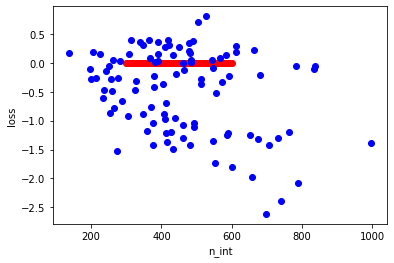

Epoch:  3400
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3401
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3402
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3403
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3404
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3405
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3406
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3407
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3408
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3409
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3410
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3411
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3412
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3502
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3503
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3504
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3505
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3506
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3507
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3508
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3509
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3510
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3511
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3512
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3513
Latent shape:  (64, 5)
Xfake shape:  (6

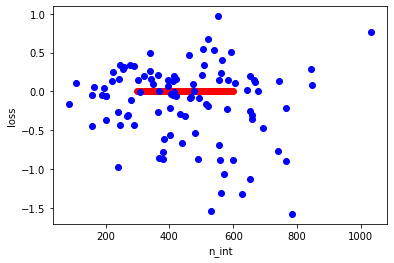

Epoch:  3600
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3601
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3602
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3603
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3604
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3605
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3606
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3607
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3608
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3609
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3610
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3611
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3612
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3702
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3703
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3704
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3705
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3706
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3707
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3708
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3709
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3710
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3711
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3712
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3713
Latent shape:  (64, 5)
Xfake shape:  (6

Epoch: 3799, Acc_real: 0.0, Acc_fake: 0.9900990099009901


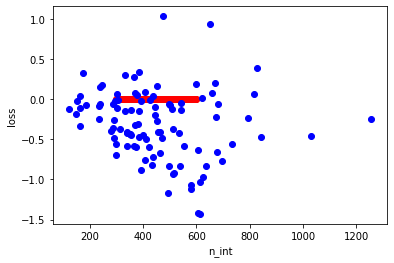

Epoch:  3800
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3801
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3802
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3803
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3804
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3805
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3806
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3807
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3808
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3809
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3810
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3811
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3812
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3902
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3903
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3904
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3905
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3906
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3907
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3908
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3909
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3910
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3911
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3912
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  3913
Latent shape:  (64, 5)
Xfake shape:  (6

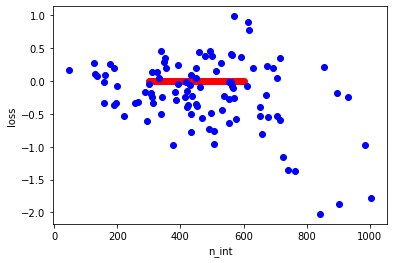

Epoch:  4000
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4001
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4002
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4003
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4004
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4005
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4006
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4007
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4008
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4009
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4010
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4011
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4012
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4103
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4104
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4105
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4106
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4107
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4108
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4109
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4110
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4111
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4112
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4113
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4114
Latent shape:  (64, 5)
Xfake shape:  (6

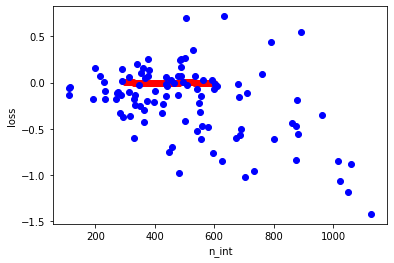

Epoch:  4200
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4201
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4202
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4203
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4204
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4205
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4206
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4207
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4208
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4209
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4210
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4211
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4212
Lat

Latent shape:  (128, 5)
Epoch:  4301
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4302
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4303
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4304
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4305
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4306
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4307
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4308
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4309
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4310
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4311
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4312
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (

Epoch: 4399, Acc_real: 1.0, Acc_fake: 0.8613861386138614


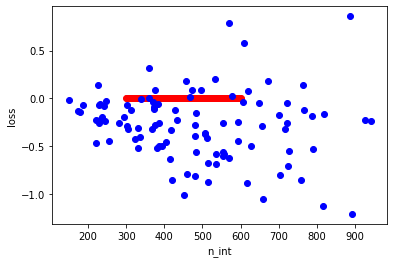

Epoch:  4400
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4401
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4402
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4403
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4404
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4405
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4406
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4407
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4408
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4409
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4410
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4411
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4412
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4505
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4506
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4507
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4508
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4509
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4510
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4511
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4512
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4513
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4514
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4515
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4516
Latent shape:  (64, 5)
Xfake shape:  (6

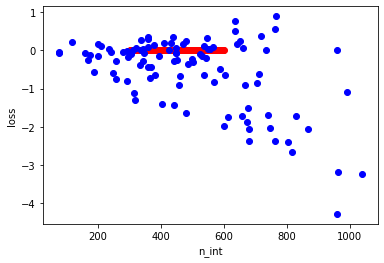

Epoch:  4600
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4601
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4602
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4603
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4604
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4605
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4606
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4607
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4608
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4609
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4610
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4611
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4612
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4702
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4703
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4704
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4705
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4706
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4707
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4708
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4709
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4710
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4711
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4712
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4713
Latent shape:  (64, 5)
Xfake shape:  (6

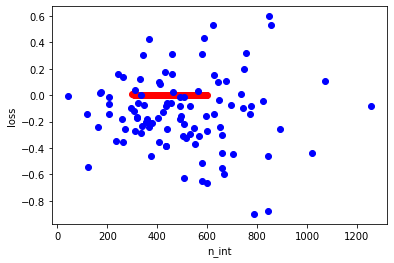

Epoch:  4800
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4801
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4802
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4803
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4804
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4805
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4806
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4807
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4808
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4809
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4810
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4811
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4812
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4902
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4903
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4904
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4905
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4906
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4907
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4908
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4909
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4910
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4911
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4912
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  4913
Latent shape:  (64, 5)
Xfake shape:  (6

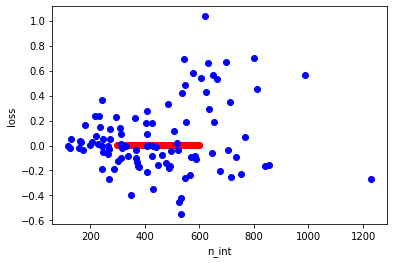

Epoch:  5000
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5001
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5002
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5003
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5004
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5005
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5006
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5007
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5008
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5009
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5010
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5011
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5012
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5102
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5103
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5104
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5105
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5106
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5107
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5108
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5109
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5110
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5111
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5112
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5113
Latent shape:  (64, 5)
Xfake shape:  (6

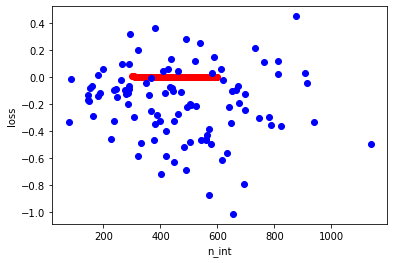

Epoch:  5200
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5201
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5202
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5203
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5204
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5205
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5206
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5207
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5208
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5209
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5210
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5211
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5212
Lat

Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5304
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5305
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5306
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5307
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5308
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5309
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5310
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5311
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5312
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5313
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5314
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5315
Latent shape:  (

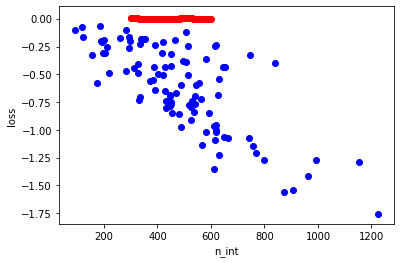

Epoch:  5400
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5401
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5402
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5403
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5404
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5405
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5406
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5407
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5408
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5409
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5410
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5411
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5412
Lat

Latent shape:  (128, 5)
Epoch:  5501
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5502
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5503
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5504
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5505
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5506
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5507
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5508
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5509
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5510
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5511
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5512
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (

4/4 - 0s - loss: 0.4652 - accuracy: 0.7525
Epoch: 5599, Acc_real: 1.0, Acc_fake: 0.7524752475247525


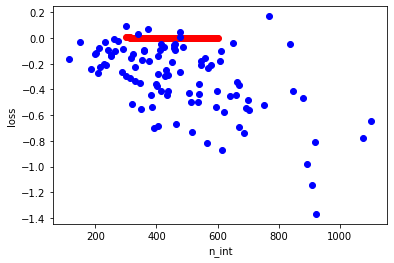

Epoch:  5600
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5601
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5602
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5603
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5604
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5605
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5606
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5607
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5608
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5609
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5610
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5611
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5612
Lat

Latent shape:  (128, 5)
Epoch:  5702
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5703
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5704
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5705
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5706
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5707
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5708
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5709
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5710
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5711
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5712
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5713
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (

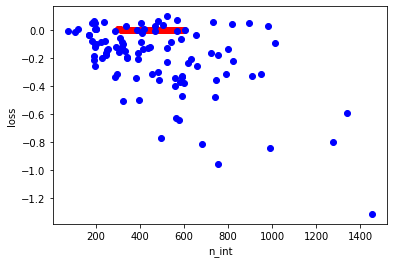

Epoch:  5800
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5801
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5802
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5803
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5804
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5805
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5806
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5807
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5808
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5809
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5810
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5811
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5812
Lat

Latent shape:  (128, 5)
Epoch:  5901
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5902
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5903
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5904
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5905
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5906
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5907
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5908
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5909
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5910
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5911
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  5912
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (

4/4 - 0s - loss: 0.3412 - accuracy: 0.9703
Epoch: 5999, Acc_real: 0.0, Acc_fake: 0.9702970297029703


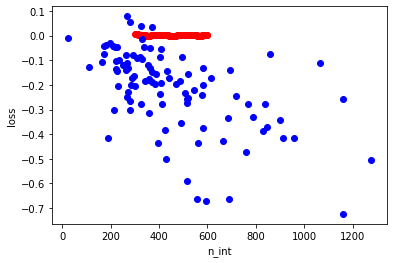

Epoch:  6000
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6001
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6002
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6003
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6004
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6005
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6006
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6007
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6008
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6009
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6010
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6011
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6012
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6106
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6107
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6108
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6109
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6110
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6111
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6112
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6113
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6114
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6115
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6116
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6117
Latent shape:  (64, 5)
Xfake shape:  (6

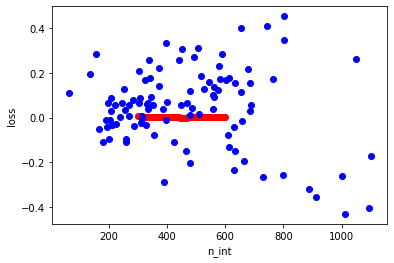

Epoch:  6200
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6201
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6202
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6203
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6204
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6205
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6206
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6207
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6208
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6209
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6210
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6211
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6212
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6301
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6302
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6303
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6304
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6305
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6306
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6307
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6308
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6309
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6310
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6311
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6312
Latent shape:  (64, 5)
Xfake shape:  (6

Latent shape:  (101, 5)
4/4 - 0s - loss: 0.4201 - accuracy: 0.9109
Epoch: 6399, Acc_real: 0.09900990099009901, Acc_fake: 0.9108910891089109


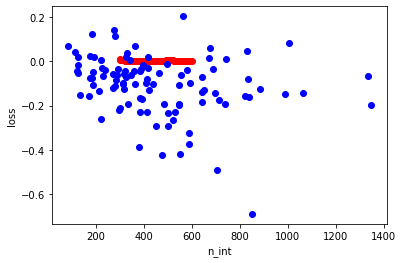

Epoch:  6400
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6401
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6402
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6403
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6404
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6405
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6406
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6407
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6408
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6409
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6410
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6411
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6412
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6502
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6503
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6504
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6505
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6506
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6507
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6508
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6509
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6510
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6511
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6512
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6513
Latent shape:  (64, 5)
Xfake shape:  (6

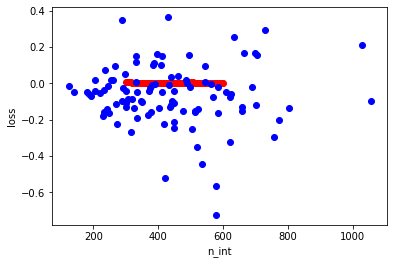

Epoch:  6600
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6601
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6602
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6603
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6604
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6605
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6606
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6607
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6608
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6609
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6610
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6611
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6612
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6701
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6702
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6703
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6704
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6705
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6706
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6707
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6708
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6709
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6710
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6711
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6712
Latent shape:  (64, 5)
Xfake shape:  (6

Latent shape:  (101, 5)
4/4 - 0s - loss: 0.4417 - accuracy: 0.7624
Epoch: 6799, Acc_real: 1.0, Acc_fake: 0.7623762376237624


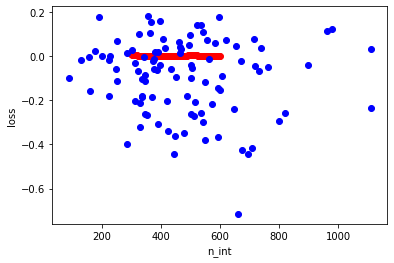

Epoch:  6800
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6801
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6802
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6803
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6804
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6805
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6806
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6807
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6808
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6809
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6810
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6811
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6812
Lat

Epoch:  6901
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6902
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6903
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6904
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6905
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6906
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6907
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6908
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6909
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6910
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6911
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6912
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  6913
Lat

Epoch: 6999, Acc_real: 1.0, Acc_fake: 0.9405940594059405


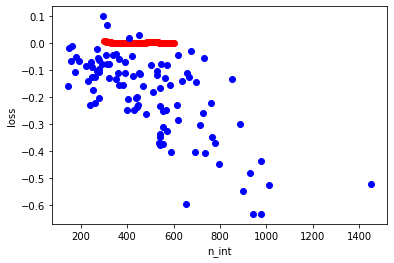

Epoch:  7000
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7001
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7002
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7003
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7004
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7005
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7006
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7007
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7008
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7009
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7010
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7011
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7012
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7101
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7102
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7103
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7104
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7105
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7106
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7107
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7108
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7109
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7110
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7111
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7112
Latent shape:  (64, 5)
Xfake shape:  (6

Latent shape:  (101, 5)
4/4 - 0s - loss: 0.6880 - accuracy: 0.4950
Epoch: 7199, Acc_real: 1.0, Acc_fake: 0.49504950495049505


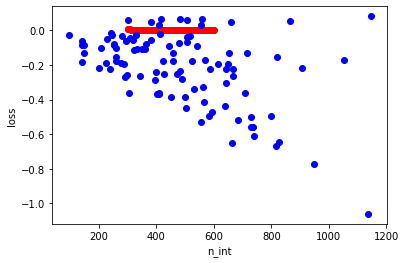

Epoch:  7200
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7201
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7202
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7203
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7204
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7205
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7206
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7207
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7208
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7209
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7210
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7211
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7212
Lat

Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7303
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7304
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7305
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7306
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7307
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7308
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7309
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7310
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7311
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7312
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7313
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7314
Latent shape:  (

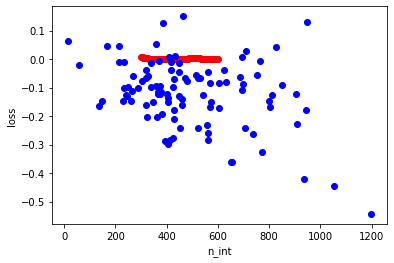

Epoch:  7400
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7401
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7402
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7403
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7404
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7405
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7406
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7407
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7408
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7409
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7410
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7411
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7412
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7504
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7505
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7506
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7507
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7508
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7509
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7510
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7511
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7512
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7513
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7514
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7515
Latent shape:  (64, 5)
Xfake shape:  (6

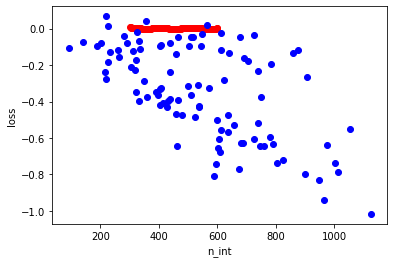

Epoch:  7600
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7601
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7602
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7603
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7604
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7605
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7606
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7607
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7608
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7609
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7610
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7611
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7612
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7704
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7705
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7706
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7707
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7708
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7709
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7710
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7711
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7712
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7713
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7714
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7715
Latent shape:  (64, 5)
Xfake shape:  (6

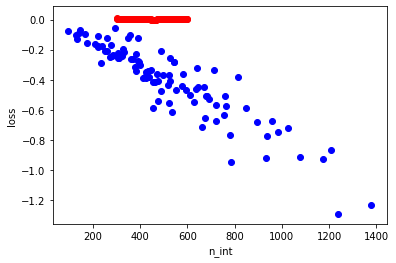

Epoch:  7800
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7801
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7802
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7803
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7804
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7805
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7806
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7807
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7808
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7809
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7810
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7811
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7812
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7902
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7903
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7904
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7905
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7906
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7907
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7908
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7909
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7910
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7911
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7912
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  7913
Latent shape:  (64, 5)
Xfake shape:  (6

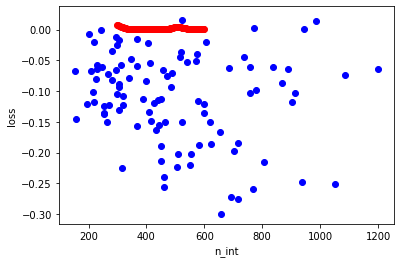

Epoch:  8000
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8001
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8002
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8003
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8004
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8005
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8006
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8007
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8008
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8009
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8010
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8011
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8012
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8103
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8104
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8105
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8106
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8107
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8108
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8109
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8110
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8111
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8112
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8113
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8114
Latent shape:  (64, 5)
Xfake shape:  (6

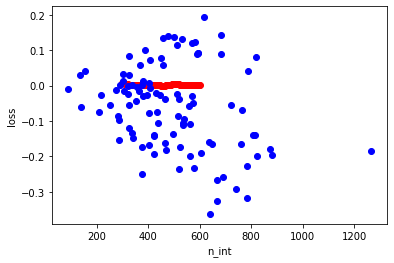

Epoch:  8200
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8201
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8202
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8203
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8204
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8205
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8206
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8207
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8208
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8209
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8210
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8211
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8212
Lat

Latent shape:  (128, 5)
Epoch:  8303
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8304
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8305
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8306
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8307
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8308
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8309
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8310
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8311
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8312
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8313
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8314
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (

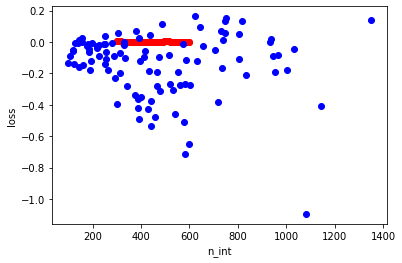

Epoch:  8400
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8401
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8402
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8403
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8404
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8405
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8406
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8407
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8408
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8409
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8410
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8411
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8412
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8502
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8503
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8504
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8505
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8506
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8507
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8508
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8509
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8510
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8511
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8512
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8513
Latent shape:  (64, 5)
Xfake shape:  (6

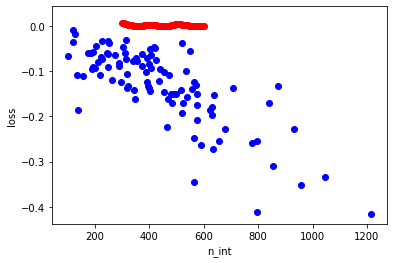

Epoch:  8600
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8601
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8602
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8603
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8604
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8605
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8606
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8607
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8608
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8609
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8610
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8611
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8612
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8701
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8702
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8703
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8704
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8705
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8706
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8707
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8708
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8709
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8710
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8711
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8712
Latent shape:  (64, 5)
Xfake shape:  (6

Latent shape:  (101, 5)
4/4 - 0s - loss: 0.3152 - accuracy: 0.9307
Epoch: 8799, Acc_real: 0.0594059405940594, Acc_fake: 0.9306930693069307


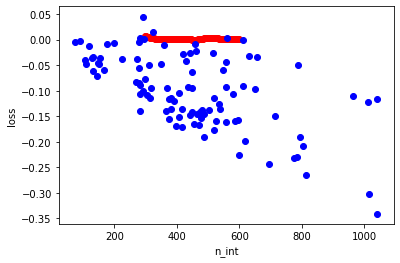

Epoch:  8800
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8801
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8802
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8803
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8804
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8805
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8806
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8807
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8808
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8809
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8810
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8811
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8812
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8901
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8902
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8903
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8904
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8905
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8906
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8907
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8908
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8909
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8910
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8911
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  8912
Latent shape:  (64, 5)
Xfake shape:  (6

Latent shape:  (101, 5)
4/4 - 0s - loss: 0.4662 - accuracy: 0.8020
Epoch: 8999, Acc_real: 1.0, Acc_fake: 0.801980198019802


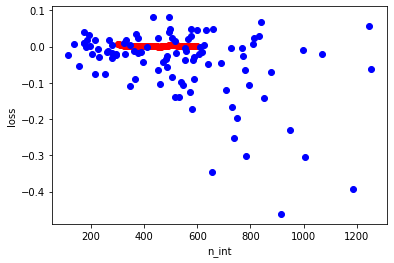

Epoch:  9000
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9001
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9002
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9003
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9004
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9005
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9006
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9007
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9008
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9009
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9010
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9011
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9012
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9102
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9103
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9104
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9105
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9106
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9107
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9108
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9109
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9110
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9111
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9112
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9113
Latent shape:  (64, 5)
Xfake shape:  (6

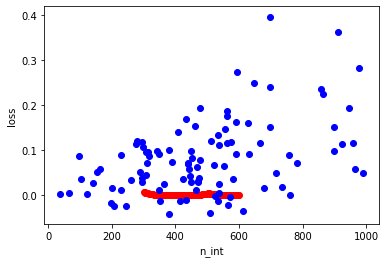

Epoch:  9200
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9201
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9202
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9203
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9204
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9205
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9206
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9207
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9208
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9209
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9210
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9211
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9212
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9301
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9302
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9303
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9304
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9305
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9306
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9307
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9308
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9309
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9310
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9311
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9312
Latent shape:  (64, 5)
Xfake shape:  (6

Latent shape:  (101, 5)
4/4 - 0s - loss: 0.5402 - accuracy: 0.6238
Epoch: 9399, Acc_real: 1.0, Acc_fake: 0.6237623762376238


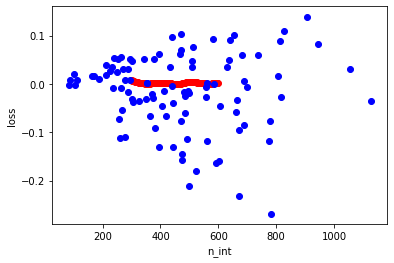

Epoch:  9400
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9401
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9402
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9403
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9404
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9405
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9406
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9407
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9408
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9409
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9410
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9411
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9412
Lat

Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9506
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9507
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9508
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9509
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9510
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9511
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9512
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9513
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9514
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9515
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9516
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9517
Latent shape:  (64, 5)
Xfake shape:  (6

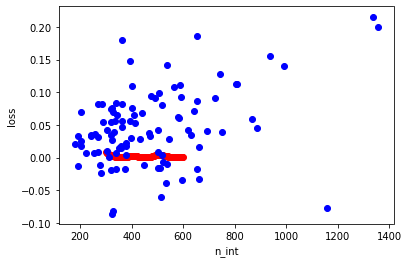

Epoch:  9600
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9601
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9602
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9603
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9604
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9605
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9606
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9607
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9608
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9609
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9610
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9611
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9612
Lat

Epoch:  9701
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9702
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9703
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9704
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9705
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9706
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9707
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9708
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9709
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9710
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9711
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9712
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9713
Lat

Epoch: 9799, Acc_real: 0.6336633663366337, Acc_fake: 0.8811881188118812


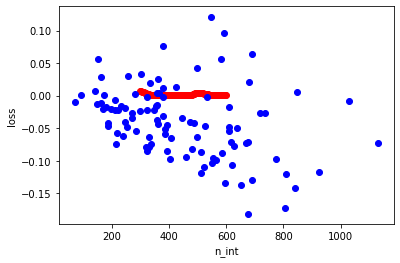

Epoch:  9800
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9801
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9802
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9803
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9804
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9805
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9806
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9807
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9808
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9809
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9810
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9811
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9812
Lat

Latent shape:  (128, 5)
Epoch:  9901
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9902
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9903
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9904
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9905
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9906
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9907
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9908
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9909
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9910
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9911
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (128, 5)
Epoch:  9912
Latent shape:  (64, 5)
Xfake shape:  (64, 2)
Latent shape:  (

4/4 - 0s - loss: 0.4138 - accuracy: 0.9406
Epoch: 9999, Acc_real: 0.0, Acc_fake: 0.9405940594059405


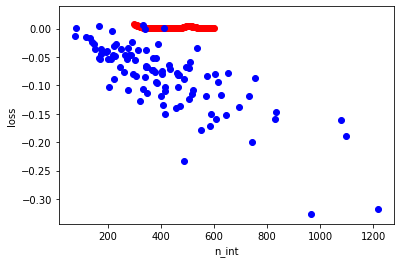

In [114]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
xfakes = train(generator, discriminator, gan_model, latent_dim)

# Heat

Let's consider the following problem:

$$
\begin{align}
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \quad u = u(t,x), \quad x\in[0,M],\\
u(0,x) = \sin(2\pi x),\\
u(t,0) = u(t,M) = 1,
\end{align}
$$


In [5]:
class framework(object):
    """The fully - connected neural network model."""
    def __init__(self, sess):
        self.sess = sess
    # parameters for the function we want to approximate
        self.domain_bound = 50   # boundary value M
        self.terminal_time = 1
        
    # parameters for the algorithm
        self.n_simple_train1 = 125 # number samples in training set 
        self.n_simple_train2 = 100
        self.n_simple_train3 = 100
        self.n_simple_train4 = 100
        self.n_simple_valid = 2000 # number samples in validation set

        self.hidden_neuron = 50  #number of neurons in each layer 
        self.n_neuron = [1, self.hidden_neuron, self.hidden_neuron, 1] 
        #structure of of neural net
        
    
        self.n_maxstep = 200000 # number of maximum iteration
        self.n_displaystep = 100 # every n_displaystep steps, we output some information
        self.picdisplaystep= 200 # every picdisplaystep steps, we output graph
        self.learning_rate = 5e-4
        
        # some basic constants and variables
        self._extra_train_ops = []
        self.tolerence = 5e-2
        
    def train(self):
        start_time = time.time()
        trainable_vars = tf.trainable_variables()
        grads = tf.gradients(self.loss, trainable_vars)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        apply_op = \
                optimizer.apply_gradients(zip(grads, trainable_vars))
        train_ops = [apply_op] + self._extra_train_ops
        self.train_op = tf.group(* train_ops)

        self.loss_history = []
        self.time_history = []
        
#=============================================================================
# You can change the code in this block if needed. But make sure always feed 
# neural net what it needs. 
        x_valid1 = self.sample_point_X1(self.n_simple_valid)
        x_valid2 = self.sample_point_X2(self.n_simple_valid)
        x_valid3 = self.sample_point_X3(self.n_simple_valid)
        x_valid4 = self.sample_point_X4(self.n_simple_valid)
        feed_dict_valid = {self.Xi: x_valid1, self.Xb1: x_valid2, self.Xt: x_valid3, self.Xb2: x_valid4, self.is_training: False}
#=============================================================================
        print("before initialized")
        
        # initialization
        step = 1
        self.sess.run(tf.global_variables_initializer())
        temp_loss = self.sess.run(self.loss,
                                  feed_dict = feed_dict_valid)
        self.loss_history.append(temp_loss)
        self.time_history.append(0)
        
        print("step: %5u, loss: %.4e," % \
              (0, temp_loss))
        
        #x_test_gradient = np.array([[0],[1],[2],[3]])
        #gradient_test = self.sess.run(self.gradient_test,
                                     #feed_dict = {self.X: x_test_gradient,
                                                 #self.is_training: False})
        
        # begin sgd iteration
        # for iii in range (self.n_maxstep + 2):
        while (self.loss_history[-1] > self.tolerence) and (step < self.n_maxstep) :
             x_train1 = self.sample_point_X1(self.n_simple_train1)
             x_train2 = self.sample_point_X2(self.n_simple_train2)
             x_train3 = self.sample_point_X3(self.n_simple_train3)
             x_train4 = self.sample_point_X4(self.n_simple_train4)
                
             self.sess.run(self.train_op,
                           feed_dict = {self.Xi: x_train1, self.Xb1: x_train2, self.Xt: x_train3, self.Xb2: x_train4,
                                       self.is_training: True})
             if step % self.n_displaystep == 0:
                 temp_loss = self.sess.run(self.loss,
                                           feed_dict = feed_dict_valid)
                 self.loss_history.append(temp_loss)
                 self.time_history.append(time.time() - start_time + self.t_bd)
                 print ("step: %5u, loss: %.4e, time: %5u" % \
                        (step , temp_loss, time.time() - start_time))

             #if step % self .picdisplaystep == 0:
                     #approximate_f = self.sess.run(self.output,
                                                   #feed_dict = feed_dict_valid)                     
                     #plt.scatter(x_valid, approximate_f, label = 'approximation of neural net')
                     #plt.scatter(x_valid, self.f(x_valid), label = 'real function f')
                     #plt.legend()
                     #plt.show()
             step += 1

        x1 = [0, 10]
        self.outputsample = self.sess.run(self.output, 
                                          feed_dict = {self.Xi: x_valid1, self.Xb1: x_valid2, 
                                                       self.Xt: x_valid3, self.Xb2: x_valid4, self.is_training: False})
#=============================================================================        
# You will need to rewrite this block. 
    def build(self):
        start_time = time.time()
        self.Xi = tf.placeholder(tf.float64, [None, 2], name = 'Xi') # interior
        self.Xb1 = tf.placeholder(tf.float64, [None, 2], name = 'Xb1') # boundary
        self.Xt = tf.placeholder(tf.float64, [None, 2], name = 'Xt') # initial
        self.Xb2 = tf.placeholder(tf.float64, [None, 2], name = 'Xb2') 
        self.is_training = tf.placeholder(tf.bool)
        
# the variable f_ is output of neural net given certain input.       
        c_interior = self._one_time_net(self.Xi, 'c')[:,0]
        c_boundary1 = self._one_time_net(self.Xb1, 'c')[:,0]
        c_boundary2 = self._one_time_net(self.Xb2, 'c')[:,0]
        c_initial = self._one_time_net(self.Xt, 'c')[:,0]
        
# loss function here is just L2 norm of difference of this two function.
        c_interior_dt = tf.gradients(c_interior, self.Xi)[0][:,0]
        c_interior_dx = tf.gradients(c_interior, self.Xi)[0][:,1]
        c_interior_dxx = tf.gradients(c_interior_dx, self.Xi)[0][:,1]
        #c_boundary_dx = tf.gradients(c_boundary, self.Xb)[0][:,1]
        
        loss_initial = c_initial - tf.math.sin(2*np.pi*self.Xt[:,1])
        loss_boundary1 = (c_boundary1 -1)
        loss_boundary2 = (c_boundary2-1)
        loss_interior = c_interior_dt - (1.0/(4.0*np.pi*np.pi))*c_interior_dxx
    
        self.loss = tf.reduce_mean((loss_initial)**2) + tf.reduce_mean((loss_boundary1)**2) + tf.reduce_mean((loss_interior)**2)+tf.reduce_mean((loss_boundary2)**2)
        
# test of tf.gradient function
        #self.gradient_test = tf.gradients(self.f(self.X), self.X)
#=============================================================================  
        self.output = c_interior
        self.t_bd = time.time() - start_time        
        print('end of build')
#=============================================================================        
# this function define how we sample points in domain
    def sample_point_X1(self, n_sample1): #interior
        t = np.random.uniform(low = 0, high = self.terminal_time, size = (n_sample1, 1))
        x = np.random.uniform(low = 0, high = self.domain_bound, size = (n_sample1, 1))
        X = np.hstack((t, x))
        X
        return X
    
    def sample_point_X2(self, n_sample2): # boundary x=M
        t = np.random.uniform(low = 0, high = self.terminal_time, size = (n_sample2, 1))
        x = np.ones((n_sample2, 1)) * self.domain_bound
        X = np.hstack((t, x))
        X
        return X
    def sample_point_X4(self, n_sample4): # boundary x=0
        t = np.random.uniform(low = 0, high = self.terminal_time, size = (n_sample4, 1))
        x = np.ones((n_sample4, 1)) * 0
        X = np.hstack((t, x))
        X
        return X
    
    def sample_point_X3(self, n_sample3): # initial t=0
        t = np.ones((n_sample3, 1)) * 0
        x = np.random.uniform(low = 0, high = self.domain_bound, size = (n_sample3, 1))
        X = np.hstack((t, x))
        X
        return X
    
# this is the function we want to approximate
#    def f(self, x):
#        return x**3
    
# you can change number of layer or activation function if needed
    def _one_time_net(self, x, name):
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            layer1 = self._one_layer(x, self.n_neuron[1], activation_fn = tf.nn.elu, name = 'layer1')
            layer2 = self._one_layer(layer1, self.n_neuron[2], activation_fn = tf.nn.relu,  name = 'layer2')
            layer3 = self._one_layer(layer2, self.n_neuron[2], activation_fn = tf.nn.relu,  name = 'layer2')
            u = self._one_layer(layer3, self.n_neuron[3], activation_fn = None ,name ='final')
        return u

# you can change initialization of weight in each layer if needed
    def _one_layer(self, input_, out_sz,
                   activation_fn = None,
                   std =1.0, name = 'linear'):
        with tf.variable_scope(name,):
            shape = input_.get_shape().as_list()
            w = tf.get_variable('Matrix',
                                [shape[1], out_sz], tf.float64,
                                norm_init(stddev = \
                                          std / np.sqrt(shape[1] + out_sz)))
            hidden = tf.matmul(input_, w)
        if activation_fn != None:
            return activation_fn(hidden)
        else:
            return hidden

#if __name__ == '__main__ ':
#    np.random.seed(1)
#    main()
#main()

with tf.Session(graph=tf.Graph()) as sess:
    tf.set_random_seed(1)
    print("begin to solve approximation")
    model = framework(sess)
    model.build()
    model.train()
    output = np.zeros((len(model.loss_history), 3))
    output[:,0] = np.arange(len(model.loss_history)) \
    * model.n_displaystep
    output[:,1] = model.loss_history
    output[:,2] = model.time_history
    outputsample = model.outputsample
    print(outputsample)

AttributeError: module 'tensorflow' has no attribute 'Session'

Text(0, 0.5, 'Convergence rate (time)')

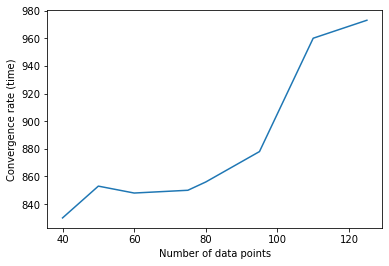

In [27]:
x = [125,110 ,95 ,80, 75 ,60 ,50, 40]
y = [973 ,960, 878, 856, 850 ,848 ,853, 830]
plt.plot(x,y)
plt.xlabel("Number of data points")
plt.ylabel("Convergence rate (time)")